Quantum Machine Learning - An example of NLP

In [1]:
import sys
sys.path.append('/Users/juriegermishuys/anaconda3/envs/qnlp/lib/python3.7/site-packages')

In [2]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
#who = Word('who', n.r @ n @ s.l @ n)
#is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob]#, who, is_rich]

![](https://miro.medium.com/max/1400/1*WEBMu7591kg2QR0uG-pALQ.png)

In [3]:
from time import time
from discopy.pregroup import brute_force

gen, n_sentences = brute_force(*vocab), 4
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.

0.06 seconds to generate 4 sentences.


Diagram for 'Alice who loves Bob is rich.':


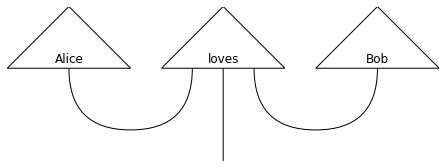

In [4]:
from discopy.pregroup import draw
print("Diagram for 'Alice who loves Bob is rich.':")
draw(parsing['Alice loves Bob.'], draw_types=False)
#draw(parsing['Alice who loves Bob is rich.'], draw_types=False)

In [5]:
from pytket.qiskit import tk_to_qiskit
from discopy import CircuitFunctor
from discopy import circuit
from discopy.circuit import sqrt, Id, Rx, CX, Ket, H, Gate

In [6]:
H = Gate("H", 1, [1, 1, 1, -1])

In [7]:
def transitive_ansatz(phase):
    return Ket(0, 0) >> H @ Rx(phase) >> CX

In [8]:
print(transitive_ansatz(0.5).eval())

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[(3.749399456654644e-33+6.123233995736766e-17j), (1-6.123233995736766e-17j), (1-6.123233995736766e-17j), (3.749399456654644e-33+6.123233995736766e-17j)])


In [9]:
transitive_circuit = Ket(0, 0) >> H @ Rx(0.5) >> CX

In [10]:
tk_circ = transitive_circuit.to_tk()
print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
print("post selection:\n{}\n".format(tk_circ.post_selection))
print("scalar:\n{}\n".format(tk_circ.scalar))
print("qiskit circuit:")
tk_to_qiskit(tk_circ).draw()

<tket::Circuit, qubits=2, gates=3>:
H q[0];
Rx(1*PI) q[1];
CX q[0], q[1];

post selection:
{}

scalar:
1

qiskit circuit:


┌───┐        
q_0: ──┤ H ├─────■──
     ┌─┴───┴──┐┌─┴─┐
q_1: ┤ RX(pi) ├┤ X ├
     └────────┘└───┘

Circuit for 'Alice loves Bob.':


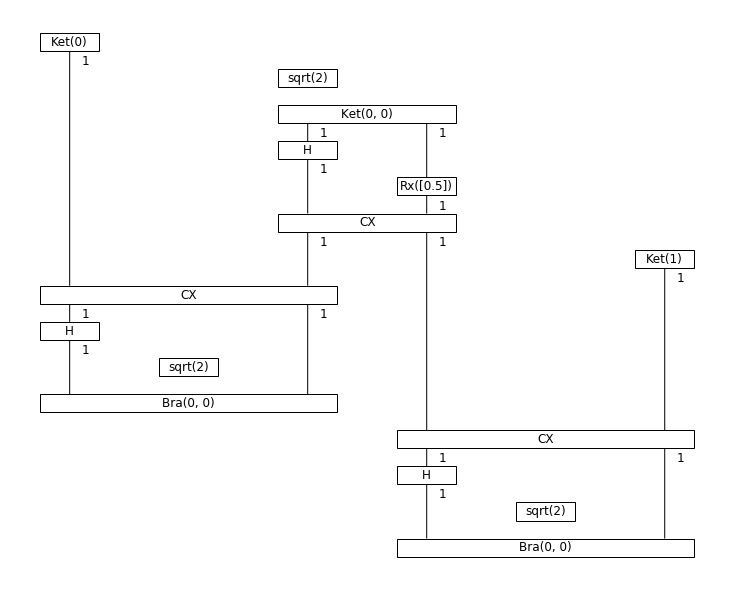

In [11]:
import numpy as np
from discopy import CircuitFunctor

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

F = lambda params: CircuitFunctor(
    ob={s: 0, n: 1},
    ar={Alice: Ket(0),
        loves: transitive_ansatz(params0),
        Bob: Ket(1)})

# NOT GATE FOR LOVES
params0 = np.array([0.5])

print("Circuit for 'Alice loves Bob.':")
circuit = F(params0)(parsing['Alice loves Bob.'])
circuit.draw(figsize=(10, 8), aspect='auto', draw_types=True)

In [12]:
tk_circ = circuit.to_tk()
print("{}:\n{}\n".format(tk_circ, '\n'.join(map(str, tk_circ))))
print("post selection:\n{}\n".format(tk_circ.post_selection))
print("scalar:\n{}\n".format(tk_circ.scalar))
print("qiskit circuit:")
tk_to_qiskit(tk_circ).draw()

<tket::Circuit, qubits=4, gates=8>:
Rx(1*PI) q[0];
X q[1];
H q[3];
CX q[3], q[0];
CX q[0], q[1];
CX q[2], q[3];
H q[0];
H q[2];

post selection:
{2: 0, 3: 0, 0: 0, 1: 0}

scalar:
2.8284271247461907

qiskit circuit:


┌────────┐┌───┐     ┌───┐
q_0: ┤ RX(pi) ├┤ X ├──■──┤ H ├
     └─┬───┬──┘└─┬─┘┌─┴─┐└───┘
q_1: ──┤ X ├─────┼──┤ X ├─────
       └───┘     │  └───┘┌───┐
q_2: ────────────┼────■──┤ H ├
       ┌───┐     │  ┌─┴─┐└───┘
q_3: ──┤ H ├─────■──┤ X ├─────
       └───┘        └───┘

In [13]:
# Scalar value to set up positive and negative examples

In [14]:
from qiskit import IBMQ
from qiskit.providers.aer import noise

In [32]:
IBMQ.save_account('b9dc79bf7c93349595bcd85b3a0dcadd06897aa41b0aa8dfabbac6ad0621db5cb7697a8b9c11372045b73db332e50c40c7dbd833d7c60d6b2cdf75fe5d312a4f',
                  overwrite=True)

In [33]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_london')
properties = device.properties()
noise_model = noise.device.basic_device_noise_model(properties)

ibmqfactory.load_account:WARNING:2020-08-30 18:59:08,492: Credentials are already in use. The existing account in the session will be replaced.
/Users/juriegermishuys/anaconda3/envs/qnlp/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:115: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


In [26]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from pytket.backends.ibm import AerBackend, IBMQBackend
from discopy.tk_interface import tensor_from_counts


In [176]:
singapore = IBMQBackend('ibmq_santiago')

In [30]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = 0.5
        self.shots = shots
        
        def create_circuit():
            ckt = tk_to_qiskit(tk_circ)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        print(counts)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects
    
    def evaluate(self, params, sentences, backend, n_shots=2**10, seed=42):
        print(sentences)
        circuits = [F(params)(parsing[s]).to_tk().measure_all() for s in sentences]
        list(map(backend.default_compilation_pass.apply, circuits))
        backend.process_circuits(circuits, n_shots=n_shots, seed=seed)
        tensors = [tensor_from_counts(
            backend.get_counts(c, n_shots=n_shots),
            c.post_selection, c.scalar).array for c in circuits]
        return self.N_qubit_expectation_Z(tensors, n_shots,4)

In [31]:
qckt = QiskitCircuit(100)

In [32]:
qckt.evaluate(params=params0, sentences=sentences, backend=AerBackend())

['Alice loves Alice.', 'Alice loves Bob.', 'Bob loves Alice.', 'Bob loves Bob.']
[array(0.), array(0.984375), array(1.09375), array(0.)]


AttributeError: 'list' object has no attribute 'keys'

In [101]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        print(tensor)
        num_list += [tensor.item()]
    return num_list

In [69]:
qckt.run(sentences)

Alice loves Alice.


AttributeError: 'str' object has no attribute 'item'

In [62]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
#import torch.nn.functional as F

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [63]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

In [64]:
qc = TorchCircuit.apply

In [34]:
from pytket.backends.ibm import AerBackend, IBMQBackend
from discopy.tk_interface import tensor_from_counts

# backend = IBMQ singapore
singapore = IBMQBackend('ibmq_london')
#backend = provider.get_backend('ibmq_qasm_simulator')

def evaluate(params, sentences, backend=singapore, n_shots=2**10, seed=42):
    circuits = [F(params)(parsing[s]).to_tk().measure_all() for s in sentences]
    list(map(backend.default_compilation_pass.apply, circuits))
    backend.process_circuits(circuits, n_shots=n_shots, seed=seed)
    return [tensor_from_counts(
        backend.get_counts(c, n_shots=n_shots),
        c.post_selection, c.scalar).array for c in circuits]

In [35]:
from time import time

start = time()
corpus = dict(zip(sentences, evaluate(params0, sentences, backend=AerBackend())))
print("{:.3f} seconds to compute the corpus.\n".format(time() - start))

delta = .1

print("True sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar > .5 + delta)))
print("False sentences:\n{}\n".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if scalar < .5 - delta)))
print("Maybe sentences:\n{}".format('\n'.join("{} ({:.3f})".format(sentence, scalar)
    for sentence, scalar in corpus.items() if .5 - delta <= scalar <= .5 + delta)))

0.217 seconds to compute the corpus.

True sentences:
Alice loves Bob. (1.102)
Bob loves Alice. (1.125)

False sentences:
Alice loves Alice. (0.000)
Bob loves Bob. (0.000)

Maybe sentences:



In [36]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=777)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(str, sentence_test))))

Training set:
Bob loves Alice.
Bob loves Bob.

Testing set:
Alice loves Alice.
Alice loves Bob.


In [37]:
import numpy as np

def loss(params, sentences=sentence_train):
    return - np.mean(np.array([
        (corpus[sentence] - scalar) ** 2
        for sentence, scalar in zip(sentences, evaluate(params, sentences))]))

In [39]:
from time import time

start = time()
corpus = dict(zip(sentences, evaluate(params0, sentences, backend=AerBackend())))
print("{:.3f} seconds to compute the corpus.\n".format(time() - start))

0.222 seconds to compute the corpus.



In [40]:
from random import random, seed; seed(337)

params = np.array([random()])

print("Random initialisation: {}".format(params))

print("\nDoes Alice love Bob?")
print("Yes, she does."
      if evaluate(params, ['Alice loves Bob.'])[0] > .5 + delta
      else "No, she doesn't.")

Random initialisation: [0.2018591  0.83909858]

Does Alice love Bob?
Job Status: job has successfully run
Yes, she does.


In [ ]:
import noisyopt

i, start = 0, time()

def callback(params):
    global i
    i += 1
    print("Epoch {} ({:.0f} seconds since start): {}".format(i, time() - start, params))

result = noisyopt.minimizeSPSA(
    loss, params, paired=False, callback=callback, niter=10, a=2)
result

In [ ]:
print("Testing loss: {}".format(loss(result.x, sentences=sentence_test)))

In [ ]:
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(result.x, ['Alice who loves Bob is rich.'])[0] > .5 + delta
      else "No, she isn't.")